In [1]:
import math
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logit

from IPython.display import display

from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, Layer,
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, add, Add, Multiply)
from keras.engine import InputSpec
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import RMSprop, Adam
from keras.models import Model
from keras import metrics
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from keras.datasets import cifar10

from realnvp_helpers import Mask, FlowBatchNorm


%matplotlib inline

/home/brian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
batch_size = 10
shape = (4, 4, 3)
samples = 100

train_data = np.random.normal(0.5, 3, size=(samples,) + (shape))
print(train_data.shape)
train_data[0, :, :, :]

(100, 4, 4, 3)


array([[[ 2.39737367,  0.95210242,  0.64810124],
        [-8.22022939, -2.15657331,  2.1342171 ],
        [-3.19424176,  6.19328654,  3.47319153],
        [ 1.70353651, -0.02966626, -4.70181249]],

       [[ 1.7666883 , -0.27133969, -1.23252509],
        [ 5.97340951, -4.12588782,  4.72224904],
        [ 0.33829784,  2.35729313, -1.14711741],
        [ 1.61496026, -0.04470453, -1.24002755]],

       [[ 0.27637592, -3.07884897, -2.51646088],
        [-0.34550501, -0.10814318, -4.11307939],
        [ 1.81050528,  3.19157547,  2.69018771],
        [ 0.64265902, -0.31655335, -1.72579811]],

       [[ 3.58469524, -1.25383402,  2.03535011],
        [-0.42593855, -0.97627318,  0.02600372],
        [ 0.69820319,  1.98653491, -4.20218565],
        [-0.80496272,  7.62116342, -0.41818718]]])

In [3]:
def conv_block(input_shape, kernel_size, filters, stage, block, use_resid=True):
    ''' Adapted from resnet50 implementation in Keras '''
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    input_tensor = Input(shape=input_shape)
    x = Conv2D(filters1, (1, 1),
               kernel_initializer='he_normal',
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same',
               kernel_initializer='he_normal',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1),
               kernel_initializer='he_normal',
               name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    if use_resid:
        x = add([x, input_tensor])
    x = Activation('relu')(x)
    
    return Model(input_tensor, x, name='conv_block' + stage + block)

In [95]:
def coupling_step(input_shape, mask_type, stage):
    ''' Implements (as per paper):
        y = b * x + (1 - b) * [x * exp(s(b * x)) + t(b * x)]
    '''
    assert mask_type in ['check_even', 'check_odd', 'channel_even', 'channel_odd']
    mask_prefix = 'check' if mask_type.startswith('check') else 'channel'
    mask_opposite = 'odd' if mask_type.endswith('even') else 'even'
    
    input_tensor = Input(shape=input_shape)
    
    # Raw operations for step
    b0 = Mask(mask_type)
    b1 = Mask(mask_prefix + '_' + mask_opposite)
    s_ = conv_block(input_shape, (3, 3), (32, 32, 3), stage, '_s', use_resid=True)
    t_ = conv_block(input_shape, (3, 3), (32, 32, 3), stage, '_t', use_resid=True)
    batch = FlowBatchNorm()
       
    # Forward
    masked_input = b1(input_tensor)
    s = s_(masked_input)
    t = t_(masked_input)
    coupling = Lambda(lambda ins:  ins[0] * K.exp(ins[1]) + ins[2])([input_tensor, s, t])
    coupling_mask = b0(coupling)
    out1, out2 = Add()([masked_input, coupling_mask]), b0(s)
    out1_norm, mean, var = batch(out1)
    batch_loss = Lambda(lambda x: 0.5 * K.log(x + batch.epsilon))(var)
    
    # Reverse
   
    # Return result + masked scale for loss function
    return Model(input_tensor, [out1_norm, out2, batch_loss], name='_'.join(['coupling', mask_type, stage]))
    #return Model(input_tensor, [out1_norm, out2], name='_'.join(['coupling', mask_type, stage]))

In [96]:
def coupling_layer(input_tensor, steps, mask_type, stage):
    name_mapping = dict(enumerate(string.ascii_lowercase))
    
    # TODO: Only need check/channel, not even/odd right?
    assert mask_type in ['check_even', 'check_odd', 'channel_even', 'channel_odd']
    mask_prefix = 'check' if mask_type.startswith('check') else 'channel'
    
    input_shape = tuple(x.value for x in input_tensor.shape)
    x = input_tensor
    s_losses = []
    batch_losses = []
    for i in range(3):
        mask_type = mask_prefix + ('_even' if i % 2 == 0 else '_odd')
        step = coupling_step(input_shape, mask_type, stage=str(stage) + name_mapping[i])
        #x, s, batch_loss = step(x)
        x, s = step(x)
        s_losses.append(s)
        #batch_losses.append(batch_loss)
    
    #return x, s_losses, batch_losses
    return x, s_losses

In [106]:
def realnvp_zloss(target, z):
    # log(p_X(x)) = log(p_Z(f(x))) + log(|det(\partial f(x) / \partial X^T)|)
    # Prior is standard normal(mu=0, sigma=1)
    shape = z.shape
    return K.sum(-0.5 * np.log(math.pi) - 0.5 * z**2, axis=list(range(1, len(shape[1:]))))

def realnvp_sumloss(target, output):
    # Determinant is just sum of "s" or "batch loss" params (already log-space)
    shape = output.shape
    return K.sum(output, axis=list(range(1, len(shape))))

In [107]:
input_tensor = Input(shape=shape)
#x = conv_block(shape, (3, 3), (32, 32, 3), '0', '_s', use_resid=True)(input_tensor)
step = coupling_step(shape, 'check_even', stage=str('a') + '0')
x, s, batch_loss = step(input_tensor)
s_losses = [s, s]
batch_losses = [batch_loss, batch_loss]

#x, s_losses, batch_losses = coupling_layer(input_tensor, steps=3, mask_type='check_even', stage=1)
#x, s_losses = coupling_layer(input_tensor, steps=3, mask_type='check_even', stage=1)
s_losses = Concatenate(name='s_losses')(s_losses)
batch_losses = Concatenate(name='batch_losses')(batch_losses)

forward_model = Model(inputs=input_tensor, outputs=[x, s_losses, batch_losses])
optimizer = Adam(lr=0.001)
forward_model.compile(optimizer=optimizer, 
                      loss=[realnvp_zloss, realnvp_sumloss, realnvp_sumloss])
forward_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_173 (InputLayer)          (None, 4, 4, 3)      0                                            
__________________________________________________________________________________________________
coupling_check_even_a0 (Model)  [(None, 4, 4, 3), (N 19498       input_173[0][0]                  
__________________________________________________________________________________________________
s_losses (Concatenate)          (None, 4, 4, 6)      0           coupling_check_even_a0[1][1]     
                                                                 coupling_check_even_a0[1][1]     
__________________________________________________________________________________________________
batch_losses (Concatenate)      (None, 4, 4, 6)      0           coupling_check_even_a0[1][2]     
          

In [108]:
#early_stopping = keras.callbacks.EarlyStopping('val_loss', min_delta=50.0, patience=5)
#reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)
s = [len(train_data)] + [int(x) for x in s_losses.shape[1:]]
#s[0] = int(train_data.shape[0])
#print(train_data.shape, np.zeros(s).shape)

#index = list(range(len(train_data)))
#np.random.shuffle(index)
#assert len(index) % batch_size == 0, (len(index), batch_size)
#for i in range(len(index) // batch_size):
#    data = train_data[i * batch_size:(i + 1) * batch_size, : , :, :]
#    print(forward_model.train_on_batch(data, data))

history = forward_model.fit(
    train_data, [train_data, np.zeros(s), np.zeros(s)],
    batch_size=batch_size,
    epochs=20,
    callbacks=[TQDMNotebookCallback()], #, early_stopping, reduce_lr],
    verbose=0
)

,loss,coupling_check_even_a0_loss,s_losses_loss,batch_losses_loss
count,20.000000,20.000000,20.000000,20.000000
mean,93.534915,-19.121853,0.563702,112.093065
std,8.415755,1.307278,2.331175,6.048807
min,89.341567,-21.413466,0.000000,106.872086
0%,89.341567,-21.413466,0.000000,106.872086
25%,90.864900,-20.130177,0.000000,109.040127
50%,92.024971,-19.007449,0.000010,111.254961
75%,92.692141,-18.042383,0.001096,113.086957
95%,94.895223,-17.373452,1.290907,115.576273
99%,122.162163,-17.252121,8.608617,131.725367


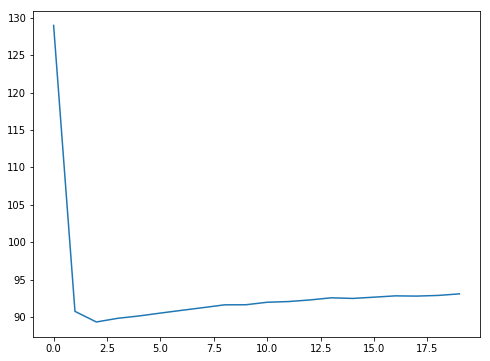

In [109]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
col = 'val_loss' if 'val_loss' in df else 'loss'
df[col][-25:].plot(figsize=(8, 6))

# 2019-07-28

* Got some framework up to do coupling layers but having trouble passing the scale parameter to the loss function, getting some weird tensorflow error, needs more debugging
* Without the determinant in the loss function, it looks like loss goes down, so maybe on the right track?
    * It's actually weird that we're not using the image in the output, but I guess that's what's great about this reversible model!
* TODO:
    * Debug scale function in loss
    * Add reverse (generator) network to functions above.

# 2019-07-29

* Explanation of how to estimate probability of continuous variables (relevant for computing bits/pixel without an explicit discrete distribution): https://math.stackexchange.com/questions/2818318/probability-that-a-sample-is-generated-from-a-distribution
* Idea for a post, explain likelihood estimation of discrete vs. continuous distributions (like pixels), include:
  * Probability of observing a value from continuous distribution = 0
     * https://math.stackexchange.com/questions/2818318/probability-that-a-sample-is-generated-from-a-distribution
  * Probability of observing a value from a set of discrete hypthesis (models) is non-zero using epsilon trick (see above link):
     * https://math.stackexchange.com/questions/920241/can-an-observed-event-in-fact-be-of-zero-probability
  * Explain Equation 3 from "A NOTE ON THE EVALUATION OF GENERATIVE MODELS"
     * Also include an example using a simpler case, like a bernoulli variable that we're estimating using a continuous distribution
  * Bring it back to modelling pixels and how they usually do it

# 2020-03-30

* To make reversible network, build forward and backward network at the same time using `Model()` to have components that I can use in both networks
* Looks like I have some instability here, depending on the run I can get an exact fit (-100s loss) or a poor a fit (+10):
    * Turning off residual networks helps
    * Adjusting the learning rate, batch size helps but hard to pinpoint a methodology
* Most likely it's the instability of using a scale parameter (RealNVP paper Section 3.7), might need to implement their batch norm for more stable results, especially when adding more layers:
    * Reimplement `BatchNorm`: https://github.com/keras-team/keras/blob/master/keras/layers/normalization.py
    * Except return regular result AND (variance + eps) term
    * Use the (var + eps) term to compute Jacobian for loss function (should just be log-additive)
* Once this is done, add back the other stuff:
    * Turn on residual shortcuts
    * Change batch size to reasonable number and learning rate=0.01
* If this still doesn't work, might want to implement "Running average over recent minibatches" in Appendix E

# 2020-03-31

* Fixed a bug (I think) in the network where the coupling layer was wrong.  However, it still sometimes get stuck at around a loss of 5 but more often than not (on another training run) get to -10 (after 20 iters).
* Trying to get FlowBatchNorm worknig but having some issues passing the determinant batch loss as an output because the `batch_size` is not getting passed (it has dimension (3,) but should have dimension (None, 3)).  Need to figure out how to tranlate a tensor to Layer that includes batch.

# 2020-04-05

* Reminder: BatchNormalization on conv layers only need to normalize across [B, W, H, :] layers, not the "C" layer because the filter is identical across a channel (so it uses the same mean/var to normalize).  This is nice because it's the same axis (-1) you would normalize across in a Dense layer. See: https://intellipaat.com/community/3872/batch-normalization-in-convolutional-neural-network
* I think I figured out how to return the batchnorm weights back but now I'm hitting a roadblock when I try to merge them together to put as part of the output loss -- maybe I should just forget it and use the tensors directly in the output loss?
* Now that I switched to an explicit batch size, it doesn't run anymore... get this error "Incompatible shapes: [4] vs. [32]", probably some assumption that I had, got to work backwards and fix it I think.


# 2020-04-14

* Okay figured out the weird error I was getting: when a Keras model has multiple outputs you either have to give it a list or dict of loss functions, otherwise it will apply the same loss to each output!  Of course, I just assumed that it gives you all outputs in one loss function. So silly!
* I reverted the change to explicitly set batch. Instead in the `BatchNormFlow` layer I just multiply zero by the `inputs` and then add the mean/variance.  I think this gives the right shape?
* TODOs:
  * Check that shape/computation for `BatchNormFlow`/`batch_losses` loss is correct
  * Check that loss functions are actually returning a negative log-loss (not just the log)
  * Validate the model is fitting what I want (right now I have an elbow effect as I train more) -- should there be backprop through the batch_losses? I guess not?  Check the paper and figure out what to do.
  * Add back in the bigger model that has multiple coupling layers

In [ ]:
from scipy.stats import norm

for i in range(-10, 10):
    eps = i / 1000
    l = norm.cdf(0 - eps)
    r = norm.cdf(0 + eps)
    print(eps, '\t', l - r)